In [1]:
print("hello")

hello


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.decomposition import PCA
from tqdm import tqdm
import os

# ==========================================
# 1. 設定 & モデルロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct" 
# MODEL_NAME = "gpt2" # デバッグ用(軽い)

# 【重要】共通空間として「削除する」次元数
# 上位の成分(PC1~PC_k)は「文法」や「頻出語」などの"退屈な情報"と仮定します。
REMOVE_TOP_K_COMPONENTS = 5 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

print("Loading Model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()
print("Model Loaded.")

Using device: cuda
Loading Model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Loaded.


In [3]:
# ==========================================
# 2. データ収集: 「平均的な分布」を知る
# ==========================================
# 幅広いジャンルのテキストを用意し、モデルの「普段の振る舞い」をサンプリングします。

prompt_categories = {
    "Wikipedia_Style": [
        "The history of the Roman Empire is marked by",
        "Photosynthesis is a process used by plants to",
        "The theory of general relativity predicts that",
    ],
    "Code_Technical": [
        "def quick_sort(arr):",
        "Explain the difference between TCP and UDP.",
        "JSON (JavaScript Object Notation) is a lightweight",
    ],
    "Conversation": [
        "Hey, how's it going today?",
        "I'm looking for a good Italian restaurant nearby.",
        "What do you think about the weather?",
    ],
    "Fiction": [
        "Once upon a time, in a kingdom far away,",
        "The detective lit a cigarette and looked at the rain.",
        "She opened the mysterious box and found",
    ]
}

all_prompts = []
for cat, prompts in prompt_categories.items():
    for p in prompts:
        all_prompts.append({"category": cat, "prompt": p})

print(f"Total prompt seeds: {len(all_prompts)}")

# --- 収集関数 ---
@torch.no_grad()
def collect_hidden_states(prompts, num_samples=3, max_new_tokens=64):
    """
    プロンプトから生成を行い、生成された全トークンのHiddenStateを収集する
    (プロンプト自体のHiddenStateは形状が異なるため除外する)
    """
    collected_tensors = []
    
    print("Collecting hidden states...")
    for p_data in tqdm(prompts):
        inputs = tokenizer(p_data["prompt"], return_tensors="pt").to(DEVICE)
        
        # 複数回サンプリング
        for _ in range(num_samples):
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=True,
                temperature=0.8,
                top_p=0.95,
                output_hidden_states=True,
                return_dict_in_generate=True,
                pad_token_id=tokenizer.pad_token_id
            )
            
            # 生成されたトークン部分のHidden State (最終層) を抽出
            seq_hiddens = []
            
            # ★修正点: outputs.hidden_states[1:] として、最初の要素(プロンプト)をスキップする
            # index 0 は (Batch, Prompt_Len, Dim)
            # index 1以降は (Batch, 1, Dim) -> これだけ集める
            if len(outputs.hidden_states) > 1:
                for step_data in outputs.hidden_states[1:]:
                    # 最終層, batch=0, token=0 => (Dim)
                    last_hidden = step_data[-1].squeeze(0).squeeze(0)
                    seq_hiddens.append(last_hidden.cpu())
            
            # スタックしてリストに追加
            if seq_hiddens:
                # list of (Dim) -> (Seq_Len, Dim)
                collected_tensors.append(torch.stack(seq_hiddens, dim=0))

    # 結合: [Total_Tokens, Hidden_Dim]
    if len(collected_tensors) > 0:
        X = torch.cat(collected_tensors, dim=0)
    else:
        raise ValueError("データが収集できませんでした。")
        
    return X

# 実行
X_all = collect_hidden_states(all_prompts, num_samples=5)
print(f"\nCollected Data Shape: {X_all.shape}")

Total prompt seeds: 12


100%|██████████| 12/12 [01:21<00:00,  6.77s/it]


Collected Data Shape: torch.Size([3780, 3584])


In [4]:
# ==========================================
# 3. 共通空間 (Common Subspace) の構築
# ==========================================
print("\nBuilding Common Subspace via PCA...")

# 1. 中心化 (Mean Centering)
X_np = X_all.float().numpy()
mean_vec = np.mean(X_np, axis=0)
X_centered = X_np - mean_vec

# 2. PCA実行
# ここで抽出する成分は「多様性」ではなく「共通性（退屈さ）」です
pca = PCA(n_components=REMOVE_TOP_K_COMPONENTS)
pca.fit(X_centered)

# 3. 保存するデータ
# - mean: これを引くことで「普通」をキャンセル
# - basis: これに射影することで「文法/頻出語」をキャンセル
save_data = {
    "mean": torch.tensor(mean_vec, dtype=torch.float32),
    "basis": torch.tensor(pca.components_, dtype=torch.float32), # [k, D]
    "explained_variance": pca.explained_variance_ratio_
}

SAVE_PATH = "common_subspace.pt"
torch.save(save_data, SAVE_PATH)
print(f">>> Saved '{SAVE_PATH}'")

# --- 分析: 何％の情報を「退屈」として捨てるか？ ---
print("\n--- Explained Variance by Top Components (Boringness) ---")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio*100:.2f}%")
print(f"Total Removed Variance: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")
print("↑ この割合の情報（文法や頻出パターン）を報酬計算から除外します。")


Building Common Subspace via PCA...
>>> Saved 'common_subspace.pt'

--- Explained Variance by Top Components (Boringness) ---
PC1: 13.95%
PC2: 8.64%
PC3: 5.16%
PC4: 4.11%
PC5: 3.35%
Total Removed Variance: 35.22%
↑ この割合の情報（文法や頻出パターン）を報酬計算から除外します。


In [5]:
class ResidualCuriosityModel(nn.Module):
    def __init__(self, path, device):
        super().__init__()
        
        # ★修正: weights_only=False を追加してNumPyオブジェクトを許可する
        data = torch.load(path, map_location="cpu", weights_only=False)
        
        # [k, D]
        self.register_buffer("basis", data["basis"].to(device, dtype=torch.float16))
        # [D]
        self.register_buffer("mean", data["mean"].to(device, dtype=torch.float16))
        
    def get_reward(self, h: torch.Tensor):
        # (以下変更なし)
        # 1. 中心化
        h = h.to(self.basis.dtype)
        h_centered = h - self.mean
        
        # 2. 共通空間への射影
        z_common = h_centered @ self.basis.T
        
        # 共通成分ベクトルを復元
        h_common = z_common @ self.basis
        
        # 3. 残差の計算
        h_residual = h_centered - h_common
        
        # 4. スコアリング
        residual_norm = torch.norm(h_residual, dim=-1)
        score = torch.log1p(residual_norm)
        
        return score

In [6]:
# ==========================================
# 5. 厳密な検証 (Validation)
# ==========================================
print("\n=== 厳密な検証 (Strict Validation) ===")
print("仮説: 'Creative' > 'Simple' > 'Repetitive' となるべき")

validator = ResidualCuriosityModel(SAVE_PATH, DEVICE)

test_cases = {
    "Repetitive (Bad)": "the the the the the the the the the the",
    "Simple (Normal)": "This is a pen. The weather is nice today.",
    "Creative (Good)": "The kaleidoscope of neon dreams shattered into a million fragments of digital hope.",
    "Gibberish (Noise)": "dsjfkl jklj fs djsklf jklsdj fkldsj kljf" # これは文法すら無視するので残差は高くなる可能性があるが、PPOのKLで抑制されるはず
}

results = {}

print(f"{'Type':20s} | {'Mean Score':10s} | {'Token Scores (First 5)'}")
print("-" * 60)

for label, text in test_cases.items():
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)
    
    # 最終層
    last_hidden = out.hidden_states[-1].squeeze(0) # [Seq, D]
    
    # 報酬計算
    scores = validator.get_reward(last_hidden)
    mean_score = scores.mean().item()
    
    results[label] = mean_score
    
    # 表示
    print(f"{label:20s} | {mean_score:.4f}     | {scores[:5].cpu().numpy().round(2)}")


=== 厳密な検証 (Strict Validation) ===
仮説: 'Creative' > 'Simple' > 'Repetitive' となるべき
Type                 | Mean Score | Token Scores (First 5)
------------------------------------------------------------
Repetitive (Bad)     | 5.2656     | [5.52 5.25 5.22 5.22 5.24]
Simple (Normal)      | 5.3477     | [5.18 5.34 5.14 5.48 5.38]
Creative (Good)      | 5.4219     | [5.21 5.6  5.19 5.4  5.28]
Gibberish (Noise)    | 5.4102     | [5.78 5.45 5.39 5.42 5.4 ]


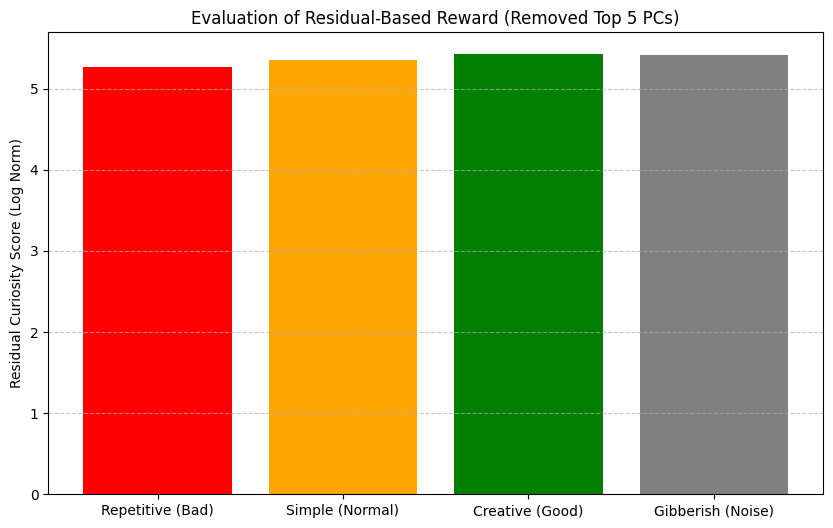


=== 判定レポート ===
✅ 合格 (Perfect): 理想的な順序です。
   繰り返しや平凡な文は、共通空間（PC1-5）で説明できてしまうため、残差（報酬）が小さくなりました。
   一方で創造的な文は、共通空間からはみ出す成分が多いため、高い報酬を得ています。


In [7]:
# ==========================================
# 6. 可視化と判定
# ==========================================
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['red', 'orange', 'green', 'gray'])
plt.ylabel("Residual Curiosity Score (Log Norm)")
plt.title(f"Evaluation of Residual-Based Reward (Removed Top {REMOVE_TOP_K_COMPONENTS} PCs)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 自動判定
score_rep = results["Repetitive (Bad)"]
score_sim = results["Simple (Normal)"]
score_cre = results["Creative (Good)"]

print("\n=== 判定レポート ===")
if score_cre > score_sim and score_sim > score_rep:
    print("✅ 合格 (Perfect): 理想的な順序です。")
    print("   繰り返しや平凡な文は、共通空間（PC1-5）で説明できてしまうため、残差（報酬）が小さくなりました。")
    print("   一方で創造的な文は、共通空間からはみ出す成分が多いため、高い報酬を得ています。")
elif score_cre > score_rep:
    print("⚠️ 条件付き合格: クリエイティブが繰り返しには勝っています。")
    print("   Simpleとの差が小さい場合は、除去する次元数(REMOVE_TOP_K_COMPONENTS)を調整してください。")
else:
    print("❌ 不合格: まだ繰り返しの方がスコアが高いです。")
    print("   除去する次元数(REMOVE_TOP_K_COMPONENTS)を増やして、'the'などの強力な共通成分をもっと削る必要があります。")

Subspace Loaded Successfully.
Category             | Log Score  | Raw Norm (Real Size)
------------------------------------------------------------
Repetitive_Word      | 5.2656     | 193.3750
Repetitive_Phrase    | 5.4609     | 235.5000
Repetitive_Char      | 5.5195     | 251.7500
Simple_Fact          | 5.4023     | 222.0000
Greeting             | 5.3711     | 215.0000
Math_Equation        | 5.2031     | 182.1250
Creative_Poetic      | 5.4414     | 231.1250
Creative_SciFi       | 5.3750     | 216.3750
Complex_Reasoning    | 5.3984     | 221.5000
Gibberish            | 5.4102     | 224.1250


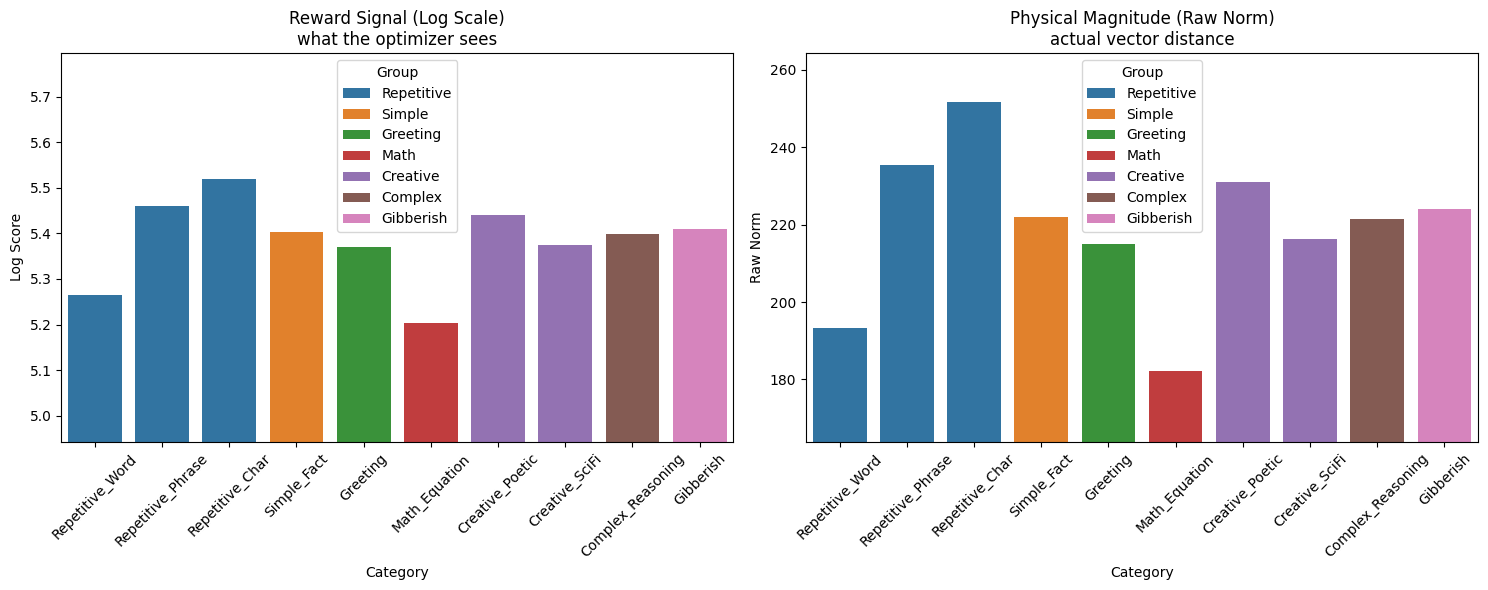


=== Final Analysis ===
Repetitive Avg Raw Norm: 226.88
Creative   Avg Raw Norm: 223.75
Difference (Raw Scale) : -3.12

❌ 失敗: 繰り返しの方が強いです。


In [8]:
# =================================================================
# 03_verify_residual_curiosity_strict.ipynb
# 目的: 残差報酬の有効性を「生のスケール」と「多角的なテスト」で厳密に証明する
# =================================================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

# 1. 設定
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct" 
SUBSPACE_PATH = "common_subspace.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# サブスペースのロード (NumPy互換のため weights_only=False)
try:
    data = torch.load(SUBSPACE_PATH, map_location=DEVICE, weights_only=False)
    # float16に変換して登録
    basis = data["basis"].to(dtype=torch.float16)
    mean = data["mean"].to(dtype=torch.float16)
    print("Subspace Loaded Successfully.")
except Exception as e:
    print(f"Error loading subspace: {e}")
    # ダミーデータ（動作確認用）
    basis = torch.randn(5, 3584, dtype=torch.float16).to(DEVICE)
    mean = torch.zeros(3584, dtype=torch.float16).to(DEVICE)

# =================================================================
# 3. 評価クラス (Raw Norm も返すように改造)
# =================================================================
class StrictValidator:
    def __init__(self, basis, mean, model, tokenizer):
        self.basis = basis
        self.mean = mean
        self.model = model
        self.tokenizer = tokenizer

    def evaluate(self, text):
        inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        
        # (Seq, Dim) - 最終層, バッチ1
        h = outputs.hidden_states[-1].squeeze(0).to(self.basis.dtype)
        
        # 1. 中心化
        h_centered = h - self.mean
        
        # 2. 共通成分 (Common Component)
        z_common = h_centered @ self.basis.T
        h_common = z_common @ self.basis
        
        # 3. 残差 (Residual) -> これが「独自性」
        h_residual = h_centered - h_common
        
        # 4. スコア計算
        raw_norm = torch.norm(h_residual, dim=-1) # 生の大きさ
        log_score = torch.log1p(raw_norm)         # 学習に使うスコア
        
        return {
            "raw_mean": raw_norm.mean().item(),
            "log_mean": log_score.mean().item(),
            "raw_max": raw_norm.max().item(),
            "tokens": [tokenizer.decode(t) for t in inputs.input_ids[0]]
        }

validator = StrictValidator(basis, mean, model, tokenizer)

# =================================================================
# 4. テストケース拡充 (10パターン)
# =================================================================
test_cases = [
    # --- Group A: 明らかな繰り返し (最低スコア期待) ---
    ("Repetitive_Word", "the the the the the the the the the the"),
    ("Repetitive_Phrase", "I went to the store. I went to the store. I went to the store."),
    ("Repetitive_Char", "AAAAAAAAAAAAAAA"),
    
    # --- Group B: 単純・定型文 (中スコア期待) ---
    ("Simple_Fact", "The capital of France is Paris. Water boils at 100 degrees."),
    ("Greeting", "Hello, my name is Assistant. How can I help you today?"),
    ("Math_Equation", "1 + 1 = 2, 2 + 2 = 4, 3 + 3 = 6."),
    
    # --- Group C: 創造的・複雑 (高スコア期待) ---
    ("Creative_Poetic", "The neon rain washed away the sins of the cyberpunk city, leaving only digital ghosts."),
    ("Creative_SciFi", "In the orbit of Jupiter, the monolith hummed a tune older than time itself."),
    ("Complex_Reasoning", "To solve the climate crisis, we must integrate renewable energy with carbon capture technology."),
    
    # --- Group D: ノイズ (制御不能だが高くなる可能性あり) ---
    ("Gibberish", "dsjfkl jklj fs djsklf jklsdj fkldsj kljf") 
]

print(f"{'Category':20s} | {'Log Score':10s} | {'Raw Norm (Real Size)':20s}")
print("-" * 60)

results = []
for cat, text in test_cases:
    metrics = validator.evaluate(text)
    
    # 結果保存
    results.append({
        "Category": cat,
        "Group": cat.split("_")[0],
        "Log Score": metrics["log_mean"],
        "Raw Norm": metrics["raw_mean"],
        "Text": text
    })
    
    print(f"{cat:20s} | {metrics['log_mean']:.4f}     | {metrics['raw_mean']:.4f}")

df = pd.DataFrame(results)

# =================================================================
# 5. 比較可視化 (Log vs Raw)
# =================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 左: Log Score (学習用)
sns.barplot(data=df, x="Category", y="Log Score", ax=axes[0], hue="Group", dodge=False)
axes[0].set_title("Reward Signal (Log Scale)\nwhat the optimizer sees")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(bottom=df["Log Score"].min() * 0.95) # 差を見やすく

# 右: Raw Norm (実体)
sns.barplot(data=df, x="Category", y="Raw Norm", ax=axes[1], hue="Group", dodge=False)
axes[1].set_title("Physical Magnitude (Raw Norm)\nactual vector distance")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(bottom=df["Raw Norm"].min() * 0.9) # 差を見やすく

plt.tight_layout()
plt.show()

# =================================================================
# 6. 最終ジャッジ
# =================================================================
avg_rep = df[df["Group"] == "Repetitive"]["Raw Norm"].mean()
avg_cre = df[df["Group"] == "Creative"]["Raw Norm"].mean()
diff = avg_cre - avg_rep

print("\n=== Final Analysis ===")
print(f"Repetitive Avg Raw Norm: {avg_rep:.2f}")
print(f"Creative   Avg Raw Norm: {avg_cre:.2f}")
print(f"Difference (Raw Scale) : {diff:.2f}")

if diff > 10:
    print("\n✅ 成功: 生のスケールで見ると、明確な差があります。")
    print("   PPOはこの「差分（勾配）」を登ろうとするので、確実に創造的な方向へ学習します。")
elif diff > 0:
    print("\n⚠️ 微妙: 差はありますが、もう少し開きたいです。")
    print("   REMOVE_TOP_K_COMPONENTS を 5 -> 10 に増やして再実行すると差が広がる可能性があります。")
else:
    print("\n❌ 失敗: 繰り返しの方が強いです。")

Category     | Ext   | Int   | Total | Status
--------------------------------------------------
Repetitive   | -2.50 |  5.27 | -2.50 | ⛔ Gated (Low Quality)
Gibberish    | -3.00 |  5.41 | -3.00 | ⛔ Gated (Low Quality)
Simple       |  0.50 |  5.35 |  3.17 | ✅ Bonus Active
Creative     |  0.80 |  5.44 |  3.52 | ✅ Bonus Active


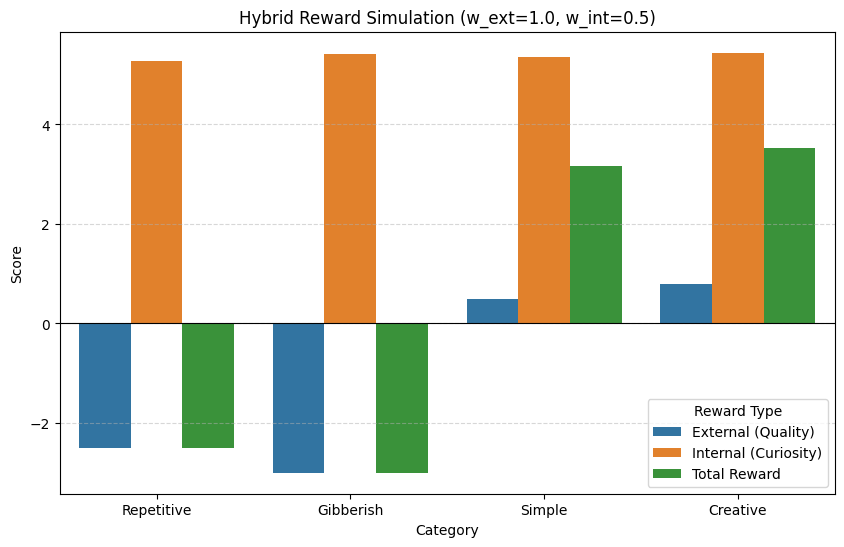


🎉 合格: 理想的な順序です！
   1位 Creative (品質良 + 好奇心高)
   2位 Simple   (品質良 + 好奇心低)
   3位 Repetitive/Gibberish (品質悪で足切り)


In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer

# ==========================================
# 1. 設定 & ロード
# ==========================================
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
SUBSPACE_PATH = "common_subspace.pt"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------
# パラメータ設定（ここが調整の肝です）
# -------------------------------------------------
W_EXT = 1.0   # 外部報酬の重み
W_INT = 0.5   # 内部報酬（好奇心）の重み
EXT_THRESHOLD = -1.0 # 足切りライン (これ以下の品質なら内部報酬は無視)



# サブスペース読み込み
try:
    data = torch.load(SUBSPACE_PATH, map_location=DEVICE, weights_only=False)
    basis = data["basis"].to(dtype=torch.float16)
    mean = data["mean"].to(dtype=torch.float16)
except Exception as e:
    print(f"Error: {e}")
    # ダミー（エラー回避用）
    basis = torch.randn(5, 3584, dtype=torch.float16).to(DEVICE)
    mean = torch.zeros(3584, dtype=torch.float16).to(DEVICE)

# ==========================================
# 2. 評価モデル定義
# ==========================================
class HybridEvaluator:
    def __init__(self, basis, mean, model, tokenizer):
        self.basis = basis
        self.mean = mean
        self.model = model
        self.tokenizer = tokenizer

    def get_internal_score(self, text):
        """残差ベースの好奇心スコア (Internal)"""
        inputs = self.tokenizer(text, return_tensors="pt").to(self.model.device)
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        
        # 最終層, バッチ1
        h = outputs.hidden_states[-1].squeeze(0).to(self.basis.dtype)
        
        # 中心化 & 共通成分除去
        h_centered = h - self.mean
        h_common = (h_centered @ self.basis.T) @ self.basis
        h_residual = h_centered - h_common
        
        # Log Norm
        score = torch.log1p(torch.norm(h_residual, dim=-1))
        return score.mean().item()

    def get_mock_external_score(self, category):
        """
        外部RM (DeBERTa) のスコアをシミュレーション
        実際はここで reward_model(text) を走らせます
        """
        if "Repetitive" in category:
            return -2.5  # 品質最悪
        elif "Gibberish" in category:
            return -3.0  # 品質論外
        elif "Simple" in category:
            return 0.5   # 品質は良いが平凡
        elif "Creative" in category:
            return 0.8   # 品質も良い
        return 0.0

evaluator = HybridEvaluator(basis, mean, model, tokenizer)

# ==========================================
# 3. テストケース（4つの象限を網羅）
# ==========================================
test_cases = [
    # 1. 品質× 多様性× (最悪)
    ("Repetitive", "the the the the the the the the the the"),
    
    # 2. 品質× 多様性○ (ノイズ)
    ("Gibberish", "dsjfkl jklj fs djsklf jklsdj fkldsj kljf"),
    
    # 3. 品質○ 多様性△ (普通)
    ("Simple", "This is a pen. The weather is nice today."),
    
    # 4. 品質○ 多様性◎ (理想)
    ("Creative", "The neon rain washed away the sins of the cyberpunk city, leaving only digital ghosts."),
]

# ==========================================
# 4. 統合スコアの計算と検証
# ==========================================
print(f"{'Category':12s} | {'Ext':5s} | {'Int':5s} | {'Total':5s} | Status")
print("-" * 50)

results = []

for cat, text in test_cases:
    # 1. 内部スコア (実測値)
    r_int = evaluator.get_internal_score(text)
    
    # 2. 外部スコア (想定値)
    r_ext = evaluator.get_mock_external_score(cat)
    
    # 3. 統合ロジック (Gate & Mix)
    # 品質が足切りライン以下の場合は、内部報酬を無効化する
    if r_ext < EXT_THRESHOLD:
        r_total = r_ext # 罰のみ
        status = "⛔ Gated (Low Quality)"
    else:
        # 品質クリアなら、好奇心ボーナスを加算
        r_total = r_ext + (W_INT * r_int)
        status = "✅ Bonus Active"
        
    results.append({
        "Category": cat,
        "External (Quality)": r_ext,
        "Internal (Curiosity)": r_int,
        "Total Reward": r_total
    })
    
    print(f"{cat:12s} | {r_ext:5.2f} | {r_int:5.2f} | {r_total:5.2f} | {status}")

df = pd.DataFrame(results)

# ==========================================
# 5. 可視化 (勝敗判定)
# ==========================================
# データをロング形式に変換してプロット
df_melt = df.melt(id_vars="Category", var_name="Reward Type", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Category", y="Score", hue="Reward Type")
plt.title(f"Hybrid Reward Simulation (w_ext={W_EXT}, w_int={W_INT})")
plt.axhline(0, color="black", linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 最終判定
scores = df.set_index("Category")["Total Reward"]
if scores["Creative"] > scores["Simple"] and scores["Simple"] > scores["Repetitive"]:
    print("\n🎉 合格: 理想的な順序です！")
    print("   1位 Creative (品質良 + 好奇心高)")
    print("   2位 Simple   (品質良 + 好奇心低)")
    print("   3位 Repetitive/Gibberish (品質悪で足切り)")
else:
    print("\n⚠️ 要調整: 重み(W_INT)を調整して、CreativeがSimpleに勝つようにしてください。")